In [1]:
%matplotlib inline

import sys
import scipy
import scipy.stats as ss
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random

In [2]:
ct_test = pd.read_csv('futuristic_city_traffic.csv')
print(ct_test.shape)
ct_test.head()

(664903, 11)


,City,Vehicle Type,Weather,Economic Condition,Day Of Week,Hour Of Day,Speed,Is Peak Hour,Random Event Occurred,Energy Consumption,Traffic Density
0,Neuroburg,2,1,1,3,16.0,100.3904,0.0,0.0,91.2640,0.0415
1,Ecoopolis,0,2,3,4,8.0,76.8000,1.0,0.0,46.0753,0.1811
2,AquaCity,2,1,0,6,16.0,45.2176,0.0,0.0,40.1934,0.4544
3,TechHaven,2,0,1,4,20.0,30.5179,0.0,0.0,37.5562,0.0843
4,Ecoopolis,2,3,1,1,21.0,43.9222,0.0,0.0,39.0420,0.0293


In [3]:
mean_rate = ct_test['Traffic Density'].mean()


# ddof is the degrees of freedom correction
# in the calculation of the standard deviation;
# for population standard deviation ddof=0
stdev_rate = ct_test['Traffic Density'].std(ddof=0)

In [4]:
print('Mean Traffic Density is {:.3f}'.format(mean_rate))
print('Standard deviation is {:.3f}'.format(stdev_rate))

Mean Traffic Density is 0.277
Standard deviation is 0.219


In [5]:
zscore_rate = ss.zscore(ct_test['Traffic Density'], ddof=0)
ct_test = ct_test.assign(zscore=zscore_rate)
ct_test.head(8)

,City,Vehicle Type,Weather,Economic Condition,Day Of Week,Hour Of Day,Speed,Is Peak Hour,Random Event Occurred,Energy Consumption,Traffic Density,zscore
0,Neuroburg,2,1,1,3,16.0,100.3904,0.0,0.0,91.2640,0.0415,-1.075055
1,Ecoopolis,0,2,3,4,8.0,76.8000,1.0,0.0,46.0753,0.1811,-0.437878
2,AquaCity,2,1,0,6,16.0,45.2176,0.0,0.0,40.1934,0.4544,0.809548
3,TechHaven,2,0,1,4,20.0,30.5179,0.0,0.0,37.5562,0.0843,-0.879703
4,Ecoopolis,2,3,1,1,21.0,43.9222,0.0,0.0,39.0420,0.0293,-1.130740
5,Ecoopolis,2,0,0,5,20.0,20.4236,0.0,0.0,18.1543,0.1393,-0.628666
6,MetropolisX,0,0,1,6,7.0,69.9735,0.0,0.0,41.8502,0.1505,-0.577546
7,SolarisVille,0,0,3,6,15.0,37.9431,0.0,0.0,18.9715,0.2485,-0.130243


In [6]:
def plot_anomaly(score_data, threshold):
    # Mask to plot values above and below threshold in different colors
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(score_data), len(score_data))
    mask_outlier = (score_data < threshold)


    plt.figure(dpi=150)
    plt.plot(ranks[~mask_outlier], score_data[~mask_outlier],'o', color='b',label='OK Traffic')
    plt.plot(ranks[mask_outlier], score_data[mask_outlier],'o', color='r', label='anomalies')
    plt.axhline(threshold,color='r',label='threshold', alpha=0.5)
    plt.legend(loc = 'lower left')
    plt.title('Z-score vs. Traffic Density', fontweight='bold')
    plt.xlabel('Ranked Traffic Density')
    plt.ylabel('Z-score')
    plt.show()

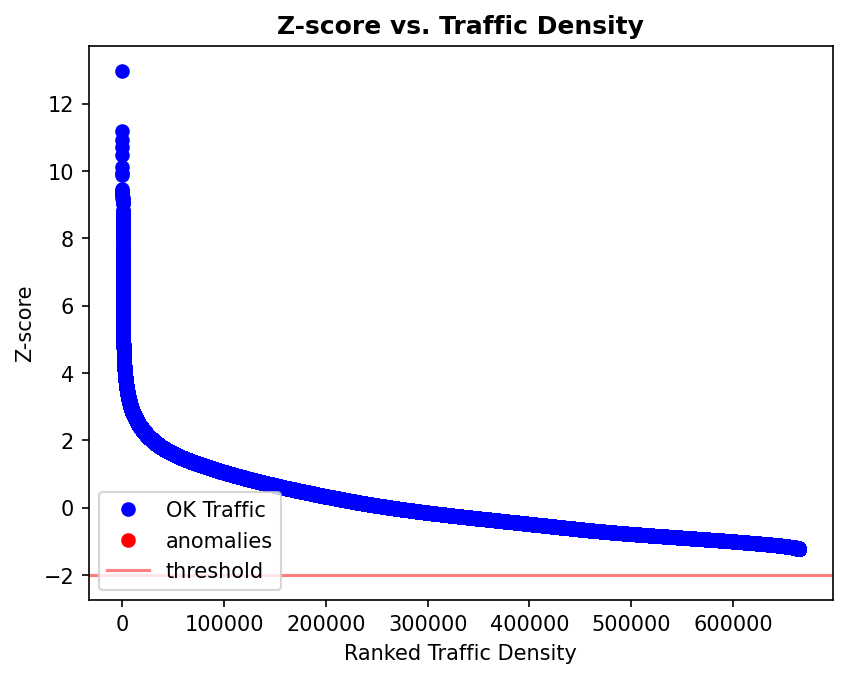

In [7]:
plot_anomaly(ct_test['zscore'], -2)

In [8]:
zscore_anomalies = ct_test[(ct_test['zscore'] < -2)]
zscore_anomalies

,City,Vehicle Type,Weather,Economic Condition,Day Of Week,Hour Of Day,Speed,Is Peak Hour,Random Event Occurred,Energy Consumption,Traffic Density,zscore


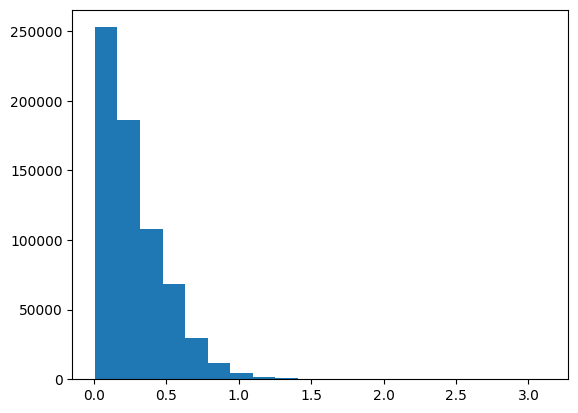

In [9]:
nbins= 20
n_hist, bins_hist, patches_hist = plt.hist(ct_test['Traffic Density'], nbins, density=False,
                           cumulative=False, linewidth=1.0, label='data')

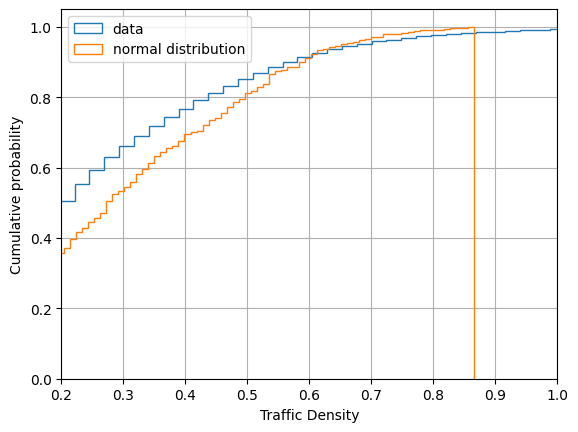

In [10]:
num_bins = 130
normal_dist = [random.gauss(mean_rate, stdev_rate) for _ in range(500)]
n, bins, patches = plt.hist(ct_test['Traffic Density'], num_bins, density=True, histtype='step',
                           cumulative=True, linewidth=1.0, label='data')
plt.hist(normal_dist, num_bins, density=True, histtype='step',
                           cumulative=True, linewidth=1.0, label='normal distribution')
plt.grid(True)
plt.legend(loc='upper left')
axes = plt.gca()
axes.set_xlim([0.2,1.0])
plt.xlabel('Traffic Density')
plt.ylabel('Cumulative probability')
plt.show()

In [11]:
def modified_zscore(data, consistency_correction=1.4826):
    """
    Returns the modified z score and Median Absolute Deviation (MAD) from the scores in data.
    The consistency_correction factor converts the MAD to the standard deviation for a given
    distribution. The default value (1.4826) is the conversion factor if the underlying data
    is normally distributed
    """
    median = np.median(data)

    deviation_from_med = np.array(data) - median

    mad = np.median(np.abs(deviation_from_med))
    mod_zscore = deviation_from_med/(consistency_correction*mad)
    return mod_zscore, mad

In [12]:
mad_zscore, mad_participation = modified_zscore(ct_test['Traffic Density'])
z_sc_participation = ct_test.assign(zscore_median=mad_zscore)

In [13]:
mod_zscore_anomalies = z_sc_participation[(z_sc_participation['zscore_median'] < -2)]
mod_zscore_anomalies

,City,Vehicle Type,Weather,Economic Condition,Day Of Week,Hour Of Day,Speed,Is Peak Hour,Random Event Occurred,Energy Consumption,Traffic Density,zscore,zscore_median


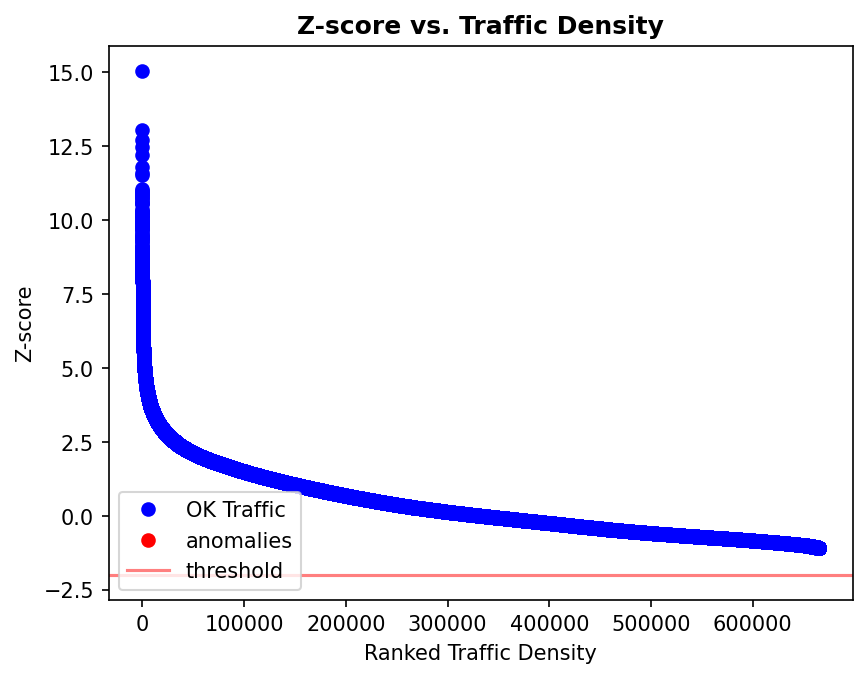

In [14]:
  plot_anomaly(z_sc_participation['zscore_median'], -2)

In [15]:
z_sc_participation['zscore_median'].describe()

count    664903.000000
mean          0.303703
std           1.136732
min          -1.102533
25%          -0.584213
50%           0.000000
75%           0.921977
max          15.051521
Name: zscore_median, dtype: float64

In [16]:
  z_sc_participation['zscore'].describe()

count    6.649030e+05
mean     1.080183e-16
std      1.000001e+00
min     -1.237088e+00
25%     -7.811138e-01
50%     -2.671726e-01
75%      5.439051e-01
max      1.297389e+01
Name: zscore, dtype: float64

In [17]:
# First row is a header row, but the header names are cumbersome.
# Skip first row and manually label
# Encoding ensures that accents in sames are rendered properly
top_goals = pd.read_csv('/content/futuristic_city_traffic.csv',
                        encoding='utf-8',
                        names=['Speed', 'Energy Consumption', 'Weather'], skiprows=1)
top_goals

,,,,,,,,Speed,Energy Consumption,Weather
Neuroburg,2,1,1,3,16.0,100.3904,0.0,0.0,91.2640,0.0415
Ecoopolis,0,2,3,4,8.0,76.8000,1.0,0.0,46.0753,0.1811
AquaCity,2,1,0,6,16.0,45.2176,0.0,0.0,40.1934,0.4544
TechHaven,2,0,1,4,20.0,30.5179,0.0,0.0,37.5562,0.0843
Ecoopolis,2,3,1,1,21.0,43.9222,0.0,0.0,39.0420,0.0293
...,...,...,...,...,...,...,...,...,...,...
TechHaven,0,2,1,6,2.0,34.2890,0.0,0.0,19.4824,0.0978
AquaCity,2,1,3,0,11.0,93.5993,0.0,0.0,74.8794,0.3706
MetropolisX,2,1,0,1,1.0,140.2007,0.0,0.0,112.1605,0.7564
TechHaven,0,3,0,6,15.0,29.2714,0.0,0.0,17.5068,0.0918


In [18]:
mean_goals = top_goals['Energy Consumption'].mean()
stdev_goals = top_goals['Energy Consumption'].std(ddof=0)
print('Mean Speed is {:.2f}'.format(mean_goals))
print('Standard deviation is {:.2f}'.format(stdev_goals))

Mean Speed is 49.46
Standard deviation is 25.27


In [19]:
zscore_goals = ss.zscore(top_goals['Energy Consumption'], ddof=0)
top_goals = top_goals.assign(zscore=zscore_goals)
top_goals.head(21)

Speed  Energy Consumption  Weather  \
Neuroburg    2 1 1 3 16.0 100.3904 0.0    0.0             91.2640   0.0415   
Ecoopolis    0 2 3 4 8.0  76.8000  1.0    0.0             46.0753   0.1811   
AquaCity     2 1 0 6 16.0 45.2176  0.0    0.0             40.1934   0.4544   
TechHaven    2 0 1 4 20.0 30.5179  0.0    0.0             37.5562   0.0843   
Ecoopolis    2 3 1 1 21.0 43.9222  0.0    0.0             39.0420   0.0293   
               0 0 5 20.0 20.4236  0.0    0.0             18.1543   0.1393   
MetropolisX  0 0 1 6 7.0  69.9735  0.0    0.0             41.8502   0.1505   
SolarisVille 0 0 3 6 15.0 37.9431  0.0    0.0             18.9715   0.2485   
Neuroburg    0 0 0 6 13.0 29.5809  1.0    0.0             14.1535   0.0626   
MetropolisX  0 2 3 2 7.0  40.4778  1.0    0.0             18.3990   0.5179   
TechHaven    2 2 1 0 7.0  87.8801  0.0    0.0             79.8910   0.1248   
Neuroburg    2 2 1 0 10.0 60.0447  0.0    0.0             57.4590   0.0342   
Ecoopolis    0 1 3 1 8.0  70.2698  1.0    0.0             35.1349   0.2389   
             3 3 3 5 9.0  66.8856  0.0    0.0             66.8856   0.2521   
Neuroburg    2 0 3 1 21.0 126.7644 0.0    0.0            107.1712   0.0784   
MetropolisX  1 2 1 5 21.0 87.0448  0.0    0.0            118.6975   0.1352   
Ecoopolis    0 1 3 5 3.0  62.3252  0.0    0.0             31.1626   0.2185   
TechHaven    2 1 0 3 19.0 67.2491  0.0    0.0             56.6070   0.1994   
Ecoopolis    2 3 0 6 1.0  69.0747  0.0    0.0             55.2598   0.2113   
               2 1 6 19.0 32.5679  0.0    0.0             26.0543   0.0550   
             3 3 1 4 5.0  94.7111  0.0    0.0             94.7111   0.0984   

                                          zscore  
Neuroburg    2 1 1 3 16.0 100.3904 0.0  1.654655  
Ecoopolis    0 2 3 4 8.0  76.8000  1.0 -0.133912  
AquaCity     2 1 0 6 16.0 45.2176  0.0 -0.366717  
TechHaven    2 0 1 4 20.0 30.5179  0.0 -0.471098  
Ecoopolis    2 3 1 1 21.0 43.9222  0.0 -0.412290  
               0 0 5 20.0 20.4236  0.0 -1.239024  
MetropolisX  0 0 1 6 7.0  69.9735  0.0 -0.301141  
SolarisVille 0 0 3 6 15.0 37.9431  0.0 -1.206679  
Neuroburg    0 0 0 6 13.0 29.5809  1.0 -1.397375  
MetropolisX  0 2 3 2 7.0  40.4778  1.0 -1.229339  
TechHaven    2 2 1 0 7.0  87.8801  0.0  1.204512  
Neuroburg    2 2 1 0 10.0 60.0447  0.0  0.316655  
Ecoopolis    0 1 3 1 8.0  70.2698  1.0 -0.566932  
             3 3 3 5 9.0  66.8856  0.0  0.689759  
Neuroburg    2 0 3 1 21.0 126.7644 0.0  2.284261  
MetropolisX  1 2 1 5 21.0 87.0448  0.0  2.740472  
Ecoopolis    0 1 3 5 3.0  62.3252  0.0 -0.724156  
TechHaven    2 1 0 3 19.0 67.2491  0.0  0.282932  
Ecoopolis    2 3 0 6 1.0  69.0747  0.0  0.229610  
               2 1 6 19.0 32.5679  0.0 -0.926342  
             3 3 1 4 5.0  94.7111  0.0  1.791091

In [20]:
def plot_anomaly_goals(score_data, threshold):
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(score_data), len(score_data))
    mask_outlier = (score_data > threshold)

    plt.figure(dpi=150)
    plt.plot(ranks[mask_outlier], score_data[mask_outlier], 'o', color='r', label='anomalies')
    plt.plot(ranks[~mask_outlier], score_data[~mask_outlier], 'o', color='b', label='typical player')
    plt.axhline(threshold,color='r', label='threshold', alpha=0.5)
    plt.legend(loc='upper right')
    plt.title('Z-score vs. Energy Consumption', fontweight='bold')
    plt.xticks(np.arange(0, 21, step=2.0))
    plt.xlabel('Energy Consumption Rank')
    plt.ylabel('Z-score')
    plt.show()

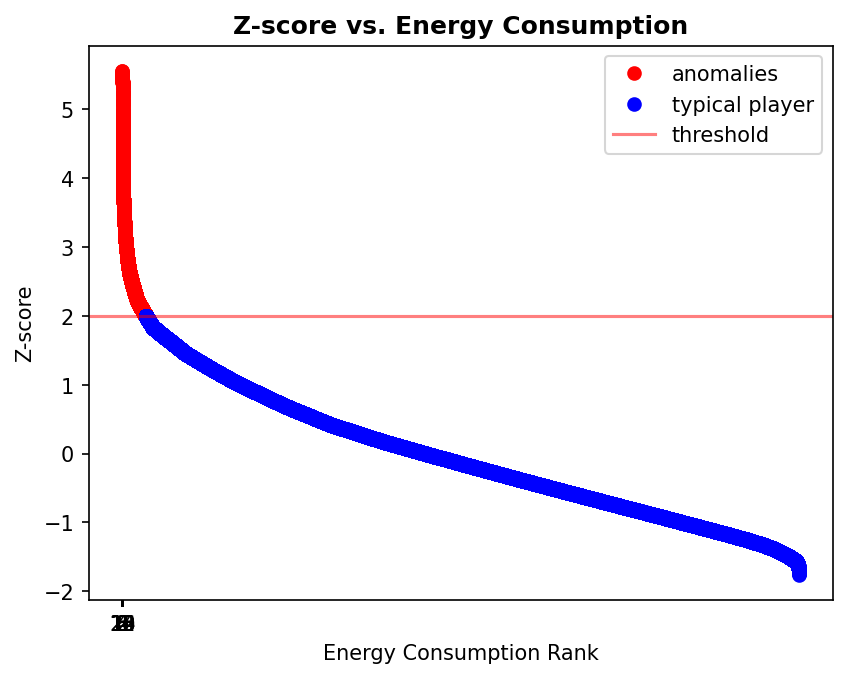

In [21]:
plot_anomaly_goals(top_goals['zscore'], 2)

In [22]:
zscore_anomalies_players = top_goals[(top_goals['zscore'] > 2)]
zscore_anomalies_players

Speed  Energy Consumption  Weather  \
Neuroburg    2 0 3 1 21.0 126.7644 0.0    0.0            107.1712   0.0784   
MetropolisX  1 2 1 5 21.0 87.0448  0.0    0.0            118.6975   0.1352   
                 3 5 12.0 114.4823 0.0    0.0            156.1122   0.4281   
             2 2 0 4 20.0 70.3384  0.0    0.0            107.9196   0.6792   
             1 3 0 6 7.0  73.6459  0.0    0.0            105.7119   0.4964   
...                                       ...                 ...      ...   
SolarisVille 1 2 0 4 2.0  97.4596  0.0    0.0            116.9515   0.4010   
AquaCity     1 2 3 1 1.0  94.8711  0.0    0.0            113.8453   0.5472   
SolarisVille 1 2 1 0 13.0 91.7954  1.0    0.0            110.1545   0.1487   
MetropolisX  2 1 0 1 1.0  140.2007 0.0    0.0            112.1605   0.7564   
Neuroburg    2 1 1 0 1.0  114.8039 0.0    0.0            104.3672   0.0507   

                                          zscore  
Neuroburg    2 0 3 1 21.0 126.7644 0.0  2.284261  
MetropolisX  1 2 1 5 21.0 87.0448  0.0  2.740472  
                 3 5 12.0 114.4823 0.0  4.221344  
             2 2 0 4 20.0 70.3384  0.0  2.313883  
             1 3 0 6 7.0  73.6459  0.0  2.226502  
...                                          ...  
SolarisVille 1 2 0 4 2.0  97.4596  0.0  2.671365  
AquaCity     1 2 3 1 1.0  94.8711  0.0  2.548422  
SolarisVille 1 2 1 0 13.0 91.7954  1.0  2.402340  
MetropolisX  2 1 0 1 1.0  140.2007 0.0  2.481738  
Neuroburg    2 1 1 0 1.0  114.8039 0.0  2.173279  

[23051 rows x 4 columns]

In [23]:
median_goals = np.median(top_goals['Energy Consumption'])
median_goals

45.8364

In [24]:
mod_zscore_goals, mad_goals = modified_zscore(top_goals['Energy Consumption'])
top_goals = top_goals.assign(mod_zscore=mod_zscore_goals)

In [25]:
def plot_anomaly_goals_2(score_data, threshold):
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(score_data), len(score_data))
    mask_outliers = (score_data > threshold)

    plt.figure(dpi=150)
    plt.plot(ranks[mask_outliers], score_data[mask_outliers],'o', color='r',label='anomalies')
    plt.plot(ranks[~mask_outliers], score_data[~mask_outliers],'o', color='b', label='typical Energy Consumption')
    plt.axhline(threshold,color='r',label='threshold', alpha=0.5)
    plt.legend(loc = 'upper right')
    plt.title('Modified z-score vs. Energy Consumption', fontweight='bold')
    plt.xticks(np.arange(0, 21, step=2.0))
    plt.xlabel('Energy Consumption')
    plt.ylabel('Modified z-score')
    plt.show()

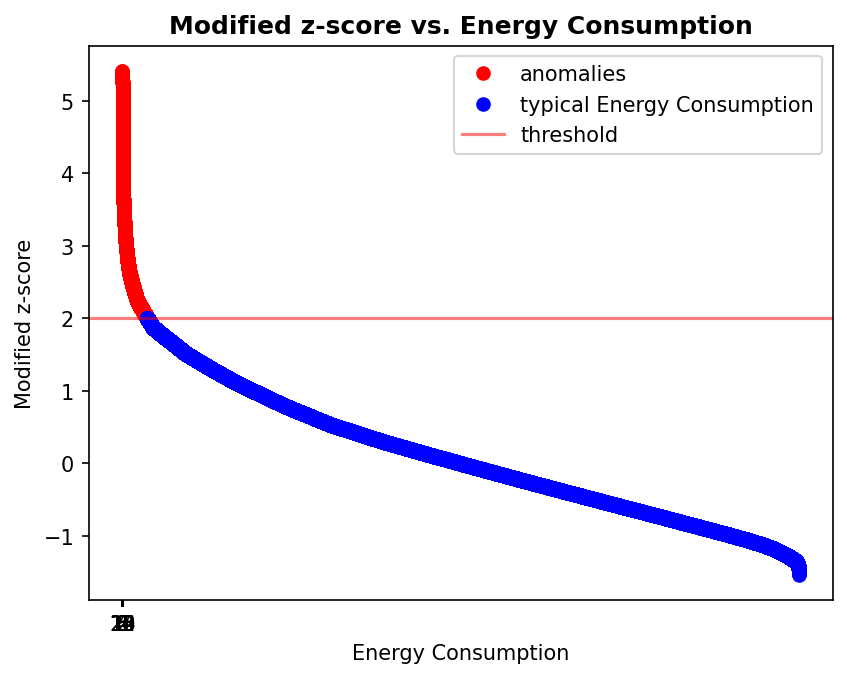

In [26]:
plot_anomaly_goals_2(top_goals['mod_zscore'], 2)

In [27]:
mod_zscore_anomalies_players = top_goals[(top_goals['mod_zscore'] > 2)]
mod_zscore_anomalies_players

Speed  Energy Consumption  Weather  \
Neuroburg    2 0 3 1 21.0 126.7644 0.0    0.0            107.1712   0.0784   
MetropolisX  1 2 1 5 21.0 87.0448  0.0    0.0            118.6975   0.1352   
                 3 5 12.0 114.4823 0.0    0.0            156.1122   0.4281   
             2 2 0 4 20.0 70.3384  0.0    0.0            107.9196   0.6792   
Neuroburg    2 0 0 5 8.0  108.3456 1.0    0.0             99.5715   0.0800   
...                                       ...                 ...      ...   
SolarisVille 1 2 0 4 2.0  97.4596  0.0    0.0            116.9515   0.4010   
AquaCity     1 2 3 1 1.0  94.8711  0.0    0.0            113.8453   0.5472   
SolarisVille 1 2 1 0 13.0 91.7954  1.0    0.0            110.1545   0.1487   
MetropolisX  2 1 0 1 1.0  140.2007 0.0    0.0            112.1605   0.7564   
Neuroburg    2 1 1 0 1.0  114.8039 0.0    0.0            104.3672   0.0507   

                                          zscore  mod_zscore  
Neuroburg    2 0 3 1 21.0 126.7644 0.0  2.284261    2.304889  
MetropolisX  1 2 1 5 21.0 87.0448  0.0  2.740472    2.738033  
                 3 5 12.0 114.4823 0.0  4.221344    4.144033  
             2 2 0 4 20.0 70.3384  0.0  2.313883    2.333013  
Neuroburg    2 0 0 5 8.0  108.3456 1.0  1.983466    2.019301  
...                                          ...         ...  
SolarisVille 1 2 0 4 2.0  97.4596  0.0  2.671365    2.672421  
AquaCity     1 2 3 1 1.0  94.8711  0.0  2.548422    2.555693  
SolarisVille 1 2 1 0 13.0 91.7954  1.0  2.402340    2.416998  
MetropolisX  2 1 0 1 1.0  140.2007 0.0  2.481738    2.492381  
Neuroburg    2 1 1 0 1.0  114.8039 0.0  2.173279    2.199518  

[24512 rows x 5 columns]

In [28]:
print('The value of MAD is {:.2f}'.format(mad_goals))

The value of MAD is 17.95


In [29]:
import numpy as np
import sklearn.datasets as sk_data
import sklearn.neighbors as neighbors
import sys

#np.set_printoptions(suppress=True, precision=4)

In [30]:
Y = np.array([[0.9, 1], [0, 1], [1, 0], [0, 0], [0.5, 0.5], [0.2, 0.5], [1, 0.5], [2, 2]])
print(Y[:, 0])# all row values for zeroth column
print(Y[:, 1])#all row value for 1st column

[0.9 0.  1.  0.  0.5 0.2 1.  2. ]
[1.  1.  0.  0.  0.5 0.5 0.5 2. ]


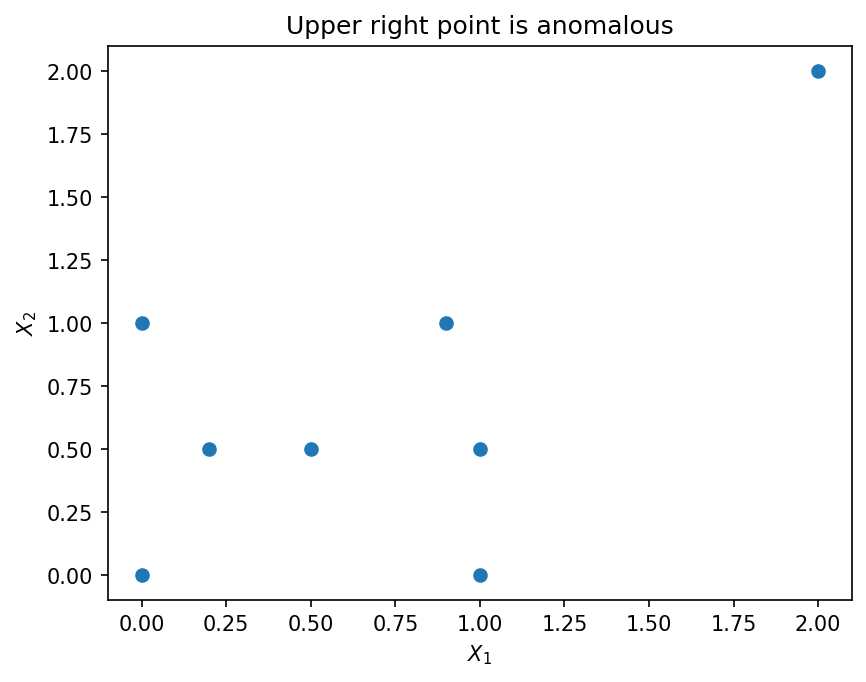

In [31]:
X = np.array([[0.9, 1], [0, 1], [1, 0], [0, 0], [0.5, 0.5], [0.2, 0.5], [1, 0.5], [2, 2]])

plt.figure(dpi=150)
plt.title('Upper right point is anomalous')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.plot(X[:, 0], X[:, 1], 'o');

In [32]:
def plot_point_and_k_neighbors(X, highlight_index, n_neighbors=2):
    "Plots the points in X, and shows the n_neighbors of the highlight_index-th point"
    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors).fit(X)#The fit() method takes the training data as arguments,
    #which can be one array in the case of unsupervised learning
    dist, index = nn.kneighbors()
    #print(dist)
    #print(index)
    src_pt = X[highlight_index, :]
    #print(src_pt)
    plt.figure(dpi=150)
    # draw lines first, so points go on top
    #print(index[highlight_index])
    for dest_index in index[highlight_index]:
        dest_pt = X[dest_index, :]
        #print(list(zip(src_pt, dest_pt)))
        plt.plot(*list(zip(src_pt, dest_pt)),'k--')
    plt.plot(X[:, 0], X[:, 1], 'o', label='Not k-neighbors', alpha=0.3)
    plt.plot(src_pt, 'o', label='The query point')
    #print(index[highlight_index])
    #print(X[index[highlight_index], 0], X[index[highlight_index], 1])
    plt.plot(X[index[highlight_index], 0], X[index[highlight_index], 1], 'o', label='k-neighbors')
    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$')
    plt.legend()

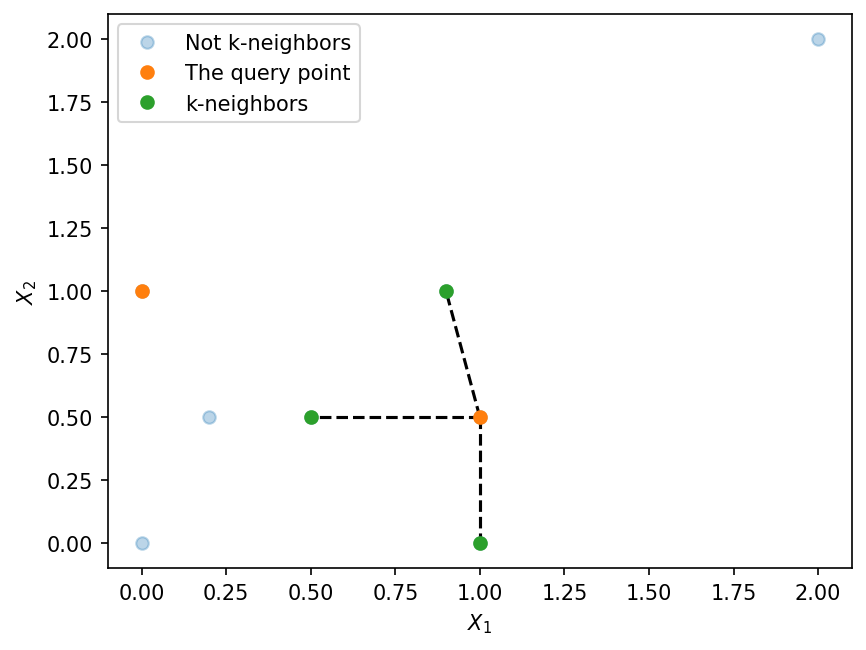

In [33]:
plot_point_and_k_neighbors(X, 6, n_neighbors=3)

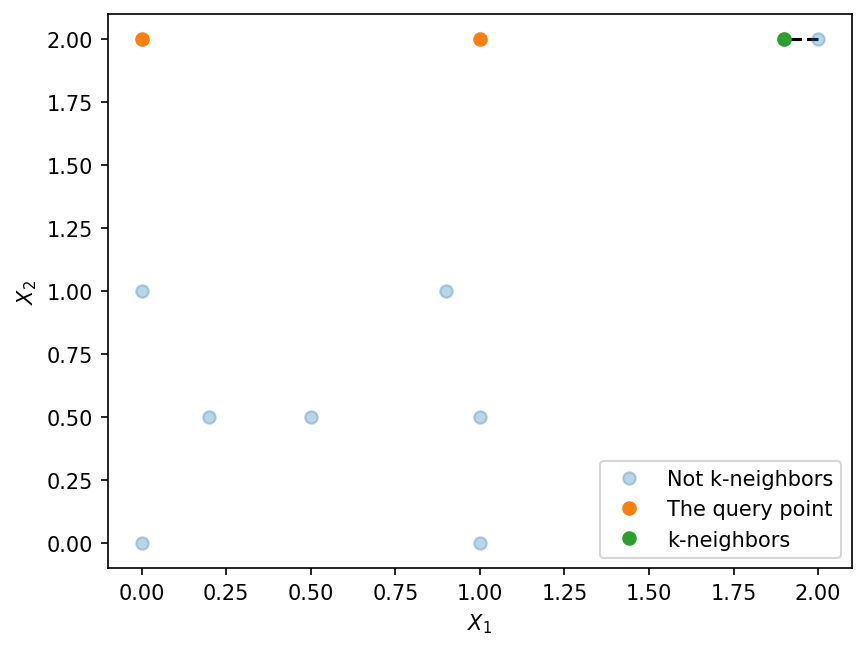

In [34]:
# Toy dataset with two adjacent anomalies
X2 = np.concatenate([X, [[1.9, 2.0]]])

# Look at nearest neighbor (k=1)
plot_point_and_k_neighbors(X2, 7, n_neighbors=1)

In [35]:
def print_ranked_scores(obs, scores):
    scores_and_obs = sorted(zip(scores, obs), key=lambda t: t[0], reverse=True)
    print('Rank  Point\t\tScore')
    print('------------------------------')
    for index, score_ob in enumerate(scores_and_obs):
        score, point = score_ob
        print(f'{index+1:3d}.  {point}\t\t{score:6.4f}')

# Look at the outliers using 3 neighbors

In [36]:
x1 = ('apple', 'banana', 'cherry')
y1 = enumerate(x1)

print(list(y1))

[(0, 'apple'), (1, 'banana'), (2, 'cherry')]


In [37]:
# LOF for KNN 3

import sklearn.neighbors as neighbors
lof = neighbors.LocalOutlierFactor(n_neighbors=3, contamination='auto')
lof.fit(X2)
sk_lof = -lof.negative_outlier_factor_#opposite LOF of given values or training sample
print_ranked_scores(X2, sk_lof)

Rank  Point		Score
------------------------------
  1.  [2. 2.]		1.8608
  2.  [1.9 2. ]		1.8293
  3.  [0.2 0.5]		1.2154
  4.  [1.  0.5]		1.2091
  5.  [0. 0.]		1.0333
  6.  [0. 1.]		1.0120
  7.  [1. 0.]		0.9554
  8.  [0.9 1. ]		0.8891
  9.  [0.5 0.5]		0.8272


In [38]:
#LOF for KNN 1

def do_nn_outlier_scores(obs, n_neighbors=1):
    """
    Gives the score of a point as the distance from point to its k-th nearest neighbor.
    Larger score means more likely to be an outlier
    """
    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(obs)
    dists, idx = nn.kneighbors()
    print(dists)
    scores = dists[:,-1]
    return scores

# Test
print_ranked_scores(X2, do_nn_outlier_scores(X2, 1))

[[0.50990195]
 [0.53851648]
 [0.5       ]
 [0.53851648]
 [0.3       ]
 [0.3       ]
 [0.5       ]
 [0.1       ]
 [0.1       ]]
Rank  Point		Score
------------------------------
  1.  [0. 1.]		0.5385
  2.  [0. 0.]		0.5385
  3.  [0.9 1. ]		0.5099
  4.  [1. 0.]		0.5000
  5.  [1.  0.5]		0.5000
  6.  [0.5 0.5]		0.3000
  7.  [0.2 0.5]		0.3000
  8.  [2. 2.]		0.1000
  9.  [1.9 2. ]		0.1000


In [39]:
def do_nn_avg_scores(obs, n_neighbors=1):

    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(obs)
    dists, idx = nn.kneighbors()
    return np.mean(dists , axis=1)

# Test
print_ranked_scores(X2,do_nn_avg_scores(X2, 3))

Rank  Point		Score
------------------------------
  1.  [2. 2.]		1.1298
  2.  [1.9 2. ]		1.0878
  3.  [0. 0.]		0.7485
  4.  [1. 0.]		0.7168
  5.  [0. 1.]		0.7152
  6.  [0.9 1. ]		0.6701
  7.  [1.  0.5]		0.5033
  8.  [0.5 0.5]		0.4801
  9.  [0.2 0.5]		0.4590


In [40]:
from scipy.stats import hmean
def do_nn_harm_scores(obs, n_neighbors=1):

    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(obs)
    dists, idx = nn.kneighbors()
    return hmean(dists , axis=1)

# Test
print_ranked_scores(X2, do_nn_harm_scores(X2, 3))

Rank  Point		Score
------------------------------
  1.  [0. 0.]		0.7024
  2.  [0. 1.]		0.6846
  3.  [1. 0.]		0.6705
  4.  [0.9 1. ]		0.6403
  5.  [1.  0.5]		0.5033
  6.  [0.5 0.5]		0.4351
  7.  [0.2 0.5]		0.4257
  8.  [2. 2.]		0.2672
  9.  [1.9 2. ]		0.2660


In [41]:
def do_lof_outlier_scores(obs, n_neighbors=3):
    neigh = neighbors.NearestNeighbors(n_neighbors=3).fit(obs)

    #Return indices of and distances to the neighbors of each point
    topk_dist, my_kneigh = neigh.kneighbors()

    # Create list of distances of furthest (kth) neighbor
    k_dist = topk_dist[:,-1]

    # Reachability distance: maximum of true distance between query neighbor and query point
    # and distance to kth nearest neighbor of query neighbor
    reach = np.maximum(topk_dist, k_dist[my_kneigh])

    # Local reacability density is reciprocal of average reachability distance
    lrd = 1.0 / np.mean(reach, axis=1)

    # Local outlier factor is given by
    # average local density of neighbors / local density of query point
    lrd_ratios = lrd[my_kneigh] / lrd[:, np.newaxis]
    lof = np.mean(lrd_ratios, axis=1)

    return lof